In [1]:
import torch
import clip
from PIL import Image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [16]:
def find_text_match(image, text_list):
    # given an image and a list of possible text matchs, find the best match
    image = preprocess(Image.open(image)).unsqueeze(0).to(device)
    text = clip.tokenize(text_list).to(device)

    with torch.no_grad():
#         image_features = model.encode_image(image)
#         text_features = model.encode_text(text)

        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    res = dict(zip(text_list, probs[0] * 100))
    return res


def find_image_match(text, image_list):
    # give a text and a list of possible image matchs, find the best match
    images = [preprocess(Image.open(img)).unsqueeze(0) for img in image_list]
    images = torch.cat(images).to(device)
    
    text = clip.tokenize([text]).to(device)
    
    with torch.no_grad():
#         image_features = model.encode_image(images)
#         text_features = model.encode_text(text)

        logits_per_image, logits_per_text = model(images, text)
        probs = logits_per_text.softmax(dim=-1).cpu().numpy()

    res = dict(zip(image_list, probs[0] * 100))
    return res


def find_image_image_match(image, image_list):
    # give a text and a list of possible image matchs, find the best match
    images = [preprocess(Image.open(img)).unsqueeze(0) for img in image_list]
    images = torch.cat(images).to(device)
    
    image = torch.cat([preprocess(Image.open(image)).unsqueeze(0)]).to(device)
    
    with torch.no_grad():
        image_features = model.encode_image(images)
        image1_features = model.encode_image(image)
        
        image_features /= image_features.norm(dim=-1, keepdim=True)
        image1_features /= image1_features.norm(dim=-1, keepdim=True)
        similarity =  100 * image_features @ image1_features.T

    res = dict(zip(image_list, similarity.reshape(-1).tolist()))
    return res

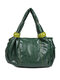

In [5]:
Image.open("a_bag.jpg")

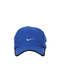

In [6]:
Image.open("a_hat.jpg")

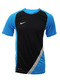

In [7]:
Image.open("a_t_shirt.jpg")

In [17]:
find_text_match(image="a_bag.jpg", text_list=["a bag", "a hat", "a cat"])

{'a bag': 99.96662, 'a hat': 0.011180727, 'a cat': 0.02220167}

In [9]:
find_text_match(image="a_bag.jpg", text_list=["a green bag", "a deep green bag", "a bag", "a blue bag"])

{'a green bag': 17.222015,
 'a deep green bag': 82.64399,
 'a bag': 0.098632365,
 'a blue bag': 0.03536507}

In [10]:
find_image_match(text="a hat", image_list=["a_bag.jpg", "a_hat.jpg"])

{'a_bag.jpg': 0.022959646, 'a_hat.jpg': 99.97704}

In [11]:
find_image_match(text="a shirt", image_list=["a_bag.jpg", "a_hat.jpg", "a_t_shirt.jpg"])

{'a_bag.jpg': 0.016090684, 'a_hat.jpg': 0.5504194, 'a_t_shirt.jpg': 99.433495}

In [12]:
find_image_image_match(image="a_bag.jpg", image_list=["a_bag.jpg", "a_hat.jpg", "a_t_shirt.jpg"])

{'a_bag.jpg': 99.99999237060547,
 'a_hat.jpg': 69.71790313720703,
 'a_t_shirt.jpg': 68.84834289550781}